In [4]:
# %matplotlib notebook
from matplotlib import pyplot as plot
from matplotlib import cm

In [5]:
import numpy
from collections import OrderedDict

In [6]:
fname = './routes.dat'

In [7]:
# Airport ID	Unique OpenFlights identifier for this airport.
# Name	Name of airport. May or may not contain the City name.
# City	Main city served by airport. May be spelled differently from Name.
# Country	Country or territory where airport is located. See countries.dat to cross-reference to ISO 3166-1 codes.
# IATA	3-letter IATA code. Null if not assigned/unknown.
# ICAO	4-letter ICAO code.
# Null if not assigned.
# Latitude	Decimal degrees, usually to six significant digits. Negative is South, positive is North.
# Longitude	Decimal degrees, usually to six significant digits. Negative is West, positive is East.
# Altitude	In feet.
# Timezone	Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.
# DST	Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time
# Tz database time zone	Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".
# Type	Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.
# Source	Source of this data. "OurAirports" for data sourced from OurAirports, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions. In airports.csv, only source=OurAirports is included.

In [8]:
aid2city = OrderedDict()

idx = 0
with open('./airports-extended.dat', 'r') as f:
    for line in f:
        ll = line.strip().split(',')
        aid2city[ll[0]] = ll[2]

In [9]:
# Airline	2-letter (IATA) or 3-letter (ICAO) code of the airline.
# Airline ID	Unique OpenFlights identifier for airline (see Airline).
# Source airport	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
# Source airport ID	Unique OpenFlights identifier for source airport (see Airport)
# Destination airport	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
# Destination airport ID	Unique OpenFlights identifier for destination airport (see Airport)
# Codeshare	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
# Stops	Number of stops on this flight ("0" for direct)
# Equipment	3-letter codes for plane type(s) generally used on this flight, separated by spaces

In [10]:
airport2aid = OrderedDict()
airport2idx = OrderedDict()

idx = 0
with open('./routes.dat', 'r') as f:
    for line in f:
        ll = line.strip().split(',')
        airport2aid[ll[2]] = ll[3]
        if ll[2] not in airport2idx:
            airport2idx[ll[2]] = idx
            idx += 1
        airport2aid[ll[4]] = ll[5]
        if ll[4] not in airport2idx:
            airport2idx[ll[4]] = idx
            idx += 1
            
idx2airport = OrderedDict([(vv,kk) for kk, vv in airport2idx.items()])

In [11]:
n_airports = len(airport2idx.keys())

In [12]:
connections = numpy.zeros((n_airports, n_airports))

with open(fname, 'r') as f:
    for line in f:
        ll = line.strip().split(',')
        if ll[7] != '0':
            continue
        sidx = airport2idx[ll[2]]
        tidx = airport2idx[ll[4]]
        connections[sidx, tidx] += 1
        # connections[tidx, sidx] += 1

In [13]:
n_flights = 0

with open(fname, 'r') as f:
    for li, line in enumerate(f):
        n_flights = n_flights + 1

print(n_flights)

67663


In [14]:
weights = connections

In [15]:
per_airport = connections.sum(1)/2.
sorted_idx = numpy.argsort(per_airport)[::-1]

In [16]:
# take the top-100 most-connected airports
n_top = 100
weights_major = weights[sorted_idx[:n_top],:]
weights_major = weights_major[:,sorted_idx[:n_top]]

In [17]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)

In [18]:
fitted = svd.fit_transform(weights_major)

In [19]:
V, sv = svd.components_, svd.singular_values_

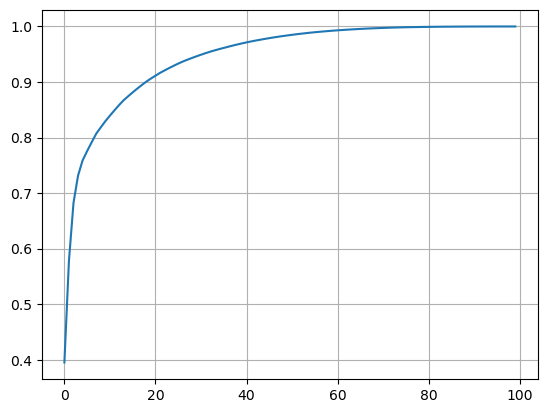

In [20]:
plot.figure()

plot.plot(numpy.cumsum((sv**2)) / numpy.sum((sv**2)))

plot.grid('on')
plot.show()

In [21]:
for vidx in range(10):
    v_sorted_idx = numpy.argsort(V[vidx,:])[::-1][:10]
    print(F'{vidx}:', ','.join(
        [F'{city} ({value:1.2f})' for city, value in
        zip(
            [aid2city.get(airport2aid[idx2airport[sorted_idx[sidx]]],'N/A') for sidx in v_sorted_idx],
            [sv[vidx] * V[vidx,sidx] for sidx in v_sorted_idx])]))

0: "London" (36.10),"Atlanta" (35.14),"New York" (31.70),"Chicago" (30.37),"Los Angeles" (28.42),"Paris" (25.67),"Frankfurt" (22.93),"San Francisco" (21.73),"Toronto" (21.29),"Dallas-Fort Worth" (20.89)
1: "Kunming" (22.47),"Chengdu" (21.99),"Xiamen" (21.44),"Hangzhou" (21.20),"Hong Kong" (20.71),"Guangzhou" (20.46),"Chongqing" (20.16),"Xi'an" (20.06),"Shanghai" (18.86),"Beijing" (18.52)
2: "Atlanta" (17.35),"Denver" (12.49),"Los Angeles" (12.15),"Phoenix" (10.71),"Minneapolis" (9.53),"Dallas-Fort Worth" (9.52),"San Francisco" (9.03),"Las Vegas" (8.28),"Chicago" (8.12),"Orlando" (8.00)
3: "Singapore" (14.36),"Bangkok" (12.82),"Kuala Lumpur" (11.85),"Tokyo" (11.05),"Jakarta" (9.96),"Seoul" (9.12),"Manila" (8.59),"Sydney" (8.18),"Delhi" (7.59),"Hong Kong" (7.44)
4: "New York" (14.66),"Chicago" (11.08),"Miami" (6.96),"Lisbon" (6.04),"Newark" (5.65),"Dallas-Fort Worth" (5.58),"Washington" (5.42),"Prague" (4.57),"Athens" (4.52),"Houston" (3.84)
5: "Chicago" (9.11),"Frankfurt" (5.39),"Cancun

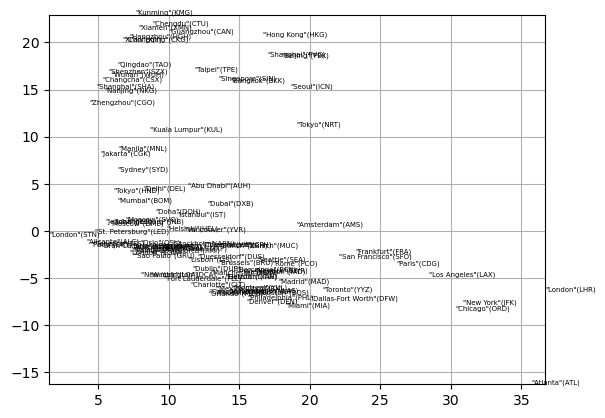

In [22]:
plot.figure()

for ii in range(fitted.shape[0]): #sorted_idx[:100]:
    airport = idx2airport[sorted_idx[ii]]
    aid = airport2aid[airport]
    if aid not in aid2city:
        continue
    city = aid2city[aid]
    plot.annotate('{}({})'.format(city,airport), (fitted[ii,0], fitted[ii,1]), fontsize=5)
    
plot.xlim([fitted.min(0)[0], fitted.max(0)[0]])
plot.ylim([fitted.min(0)[1], fitted.max(0)[1]])
plot.grid('on')

plot.show()